# Level 3: Introduction to Modeling

Now we're at one of the coolest parts of data science: modeling. When you're analyzing data, you usually have something you want to predict based on other information you have. There are many different ways to "do prediction," and we'll be covering two popular methods: *k*-nearest neighbor (KNN) and linear regression. But before we start, let's cover some terminology and concepts that are good to keep in mind when modeling.

We usually call the variable that we're trying to predict the *output variable*; the other features we use to predict said output are called *input variables.* The procedure by which predict a new data point using other data points is our *model*, and as we mentioned before, there are a variety of modeling techniques to choose from. Luckily we don't have to code them all from scratch because Python is awesome: there's a package called `scikit-learn` that does this for us. (As an aside, prediction is called *classification* if the output variable is discrete and *regression* if it is continuous.)

So what goes into building a model? Ideally we'd like it to make smart predictions -- it can *learn* from the data we have to detect underlying patterns and relationships. Maybe we could feed it our entire dataset, but then we wouldn't know how well our model actually works since we've just used up all our data. Could we just "re-use" some of the data to test out this model's predictions? If we did that, our model would make some pretty spot-on predictions. Coincidence? Not quite. If you think about it, we'd probably all do a lot better in school if we could see copies of exams before we actually take them. But life is hard and cheating is bad, so we shouldn't encourage our models to cheat either.  

This means we need to partition out the data: "hide away" a *test set* for future validation, and teach our model using a *training set.* There's no magic formula for divvying them up but usually a 60:40 or 80:20 train/test split tends to work well. In this way, our model will have just enough information to make smart predictions on the new test set that it hasn't seen before. 

To make all this more concrete, let's frame it in terms of our problem. What are we trying to do? We want to predict the precipitation on a given day based on weather data about average temperature, wind speed, etc. collected over roughly 1000 days.

Here's our first method: the *k-nearest neighbor*. The name is informative: the *k*-nearest neighbor algorithm says that for any new point, we should average the output values associated with the *k* closest points to it and call that our predicted value. This picture will give us a better idea as to what that means: 

![Nearest Neighbor Picture](nn.gif)

In this picture, *k* = 3 and we want to predict what that green dot could be. The algorithm first looks at the closest 3 points to the green dot and makes an assumption. It says, "Hey, I'm guessing that points closer to each other will be similar to each other, too." This isn't an outrageous assumption to make, especially since we tend to surround ourselves with people we "click" with -- people with whom we share certain qualities or characteristics. So this clever algorithm figures out that there are 2B's versus 1A in the dot's *3 closest neighbors* and predicts that the green dot will also be B. Cool, huh?

Now, let's use this to actually predict some precipitation! We'll first read in our cleaned up data set from the previous level.

In [1]:
import pandas as pd

data = pd.read_csv('clean_weather_data.csv')
print(data.dtypes)
data[:5]

Month                 int64
Day                   int64
Year                  int64
Mean Temperature      int64
Max Temperature       int64
Min Temperature       int64
Dew Point             int64
Average Humidity      int64
Maximum Humidity      int64
Minimum Humidity      int64
Precipitation       float64
Wind Speed          float64
Max Wind Speed      float64
Max Gust Speed      float64
dtype: object


,Month,Day,Year,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Maximum Humidity,Minimum Humidity,Precipitation,Wind Speed,Max Wind Speed,Max Gust Speed
0,1,1,2013,33,40,26,22,54,64,44,0,7,15,26
1,1,2,2013,28,33,22,11,48,57,39,0,6,15,22
2,1,3,2013,28,32,24,14,56,68,43,0,5,13,20
3,1,4,2013,34,37,30,19,56,63,48,0,8,18,28
4,1,5,2013,37,42,32,19,48,56,39,0,7,17,26


Looks like everything's good with the data -- let's now split it up into training and test sets! Thankfully `scikit-learn` already provides a function to do this. We'll use 80% of the data as training data. It's typical to separate your prediction variable from the rest of the data when modeling, so we'll follow this convention as well.

In [9]:
from sklearn.cross_validation import train_test_split

X = data.drop('Precipitation', axis=1)
y = data.Precipitation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Great! Now, let's fit our first model. We'll use *k* = 3.

In [10]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

Yay, fitting a model using `sklearn` is super simple! So how do we know how well our model did? Well, we can define a function (typically called a *loss function* among data nerds) that can take our prediction and true value, and quantify how "correct" we were.

For example, let's say we predicted $\hat{y}$ for a case that had a true value of *y*; one common loss function for regression is the squared error loss, or $(y - \hat{y})^2$. We can then compare $\sum_{i = 1}^{n}{(y_i - \hat{y_i})^2}$ to $\sum_{i = 1}^{n}{(y_i - \bar{y})^2}$ where $n$ is the number of data points we have. All this really means is adding up the loss for each individual data point. The second term is equivalent to predicting the average for every case, and if the first term is significantly less, we did much better than just random guessing. Hopefully we did well...let's find out!

In [4]:
knn_y = knn_model.predict(X_test)

knn_sum_squares = ((knn_y - y_test) ** 2).sum()
mean_sum_squares = ((y_test.mean() - y_test) ** 2).sum()

print("Average loss:", mean_sum_squares)
print("KNN loss:", knn_sum_squares)
print("Variation explained: ", 100 * (1 - knn_sum_squares / mean_sum_squares), "%", sep="")

Average loss: 53.8151391089
KNN loss: 45.3789888889
Variation explained: 15.6761654057%


We call the "variation explained" the coefficient of variation, or $r^2$. This quantity tells us how much variation, or interesting information in your data, your model explains in a meaningful way using the relationship between its input and output variables. You can also use the `score` function to automatically calculate this $r^2$.

In [5]:
print("R^2: ", knn_model.score(X_test, y_test))

R^2:  0.156761654057


Cool, we managed to fit and analyze our first model! Let's move on to linear regression.

Let's first think about predicting an output variable with only one input variable. The basic idea of linear regression is that you can aim to fit a straight line through the scatterplot, like so:

![Linear Regression](linear-regression.png)

It turns out that you can generalize this to predicting one variable using multiple variables. Let's see how we can put this into code using `sklearn`.

In [11]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Yup, KNN wasn't a special case, `sklearn` just makes things that easy. Let's see how we do.

In [12]:
print(linear_model.score(X_test, y_test))

0.207990280343


As it turns out, linear regression did better than the more simplistic KNN algorithm. One of the key ideas in data science is that you have to explore which models are best to use with your data. For fun, let's see how the two models compare by plotting the true value and the predicted value.

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


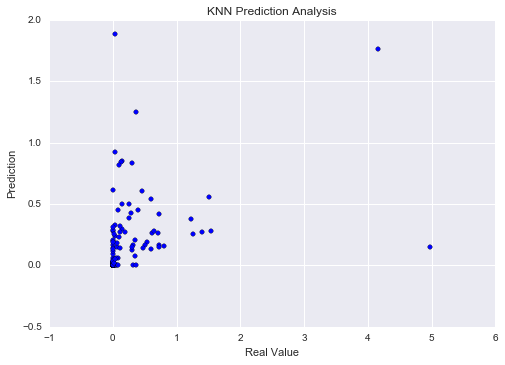

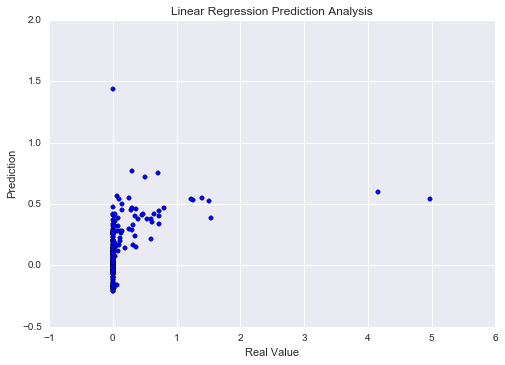

In [8]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

sns.plt.scatter(y_test, knn_model.predict(X_test))
sns.plt.title('KNN Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')
plt.show()

sns.plt.scatter(y_test, linear_model.predict(X_test))
sns.plt.title('Linear Regression Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')
plt.show()